# Rootfinding

Rootfinding is the process of solving $$f(x) = 0$$ for $x$.  The standard assumption is that $f : R \to R$ is _continuous_.  We are interested in developing general-purpose algorithms---those that can use $f(x)$ as a black box without needing to look inside.  When we implement our rootfinding algorithm in software, the user will pass a function or program to compute $f(x)$.  Rootfinding methods for differentiable functions may also use the derivative $f'(x)$.

Some questions immediately arise:
* **Existence.** When does this equation have at least one solution?
* **Uniqueness.** When is the solution unique?

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np

## Application: Elasticity

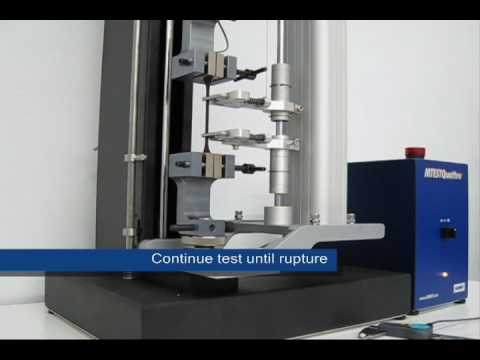

In [2]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('9N5SS8f1auI', start=60)

## Neo-Hookean model

### Strain-energy formulation

$$ W = C_1 (I_1 - 3 - 2 \log J) + D_1 (J - 1)^2 $$
where $I_1 = \lambda_1^2 + \lambda_2^2 + \lambda_3^3$ and $J = \lambda_1 \lambda_2 \lambda_3$ are *invariants* defined in terms of the principle stretches $\lambda_i$.

#### [Uniaxial extension](https://en.wikipedia.org/wiki/Neo-Hookean_solid#Compressible_neo-Hookean_material_3)

In the experiment, we would like to know the stress as a function of the stretch $\lambda_1$. We don't know $J$, and will have to determine it by solving an equation.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/Mooney-Rivlin.svg/760px-Mooney-Rivlin.svg.png)

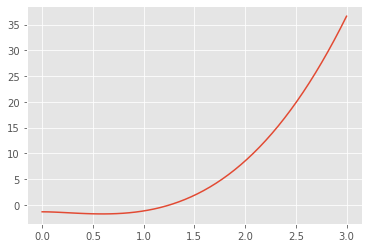

In [3]:
class NeoHookean:
    def __init__(self, C1=1, D1=3):
        self.C1 = C1
        self.D1 = D1
    def stress(self, lambda1, J):
        return 2*self.C1 / J**(5/3) * (lambda1**2 - J/lambda1)
    def f(self, lambda1, J):
        return (self.D1*J**(8/3) - self.D1*J**(5/3)
                + self.C1/(3*lambda1)*J - self.C1*lambda1**2/3)

mat = NeoHookean()
lambda1 = 2
J = np.linspace(0, 3)
plt.plot(J, mat.f(lambda1, J));

In [4]:
from scipy.optimize import root_scalar
root_scalar(lambda J: mat.f(lambda1, J), bracket=(0, 3))

      converged: True
           flag: 'converged'
 function_calls: 13
     iterations: 12
           root: 1.2561807645487126

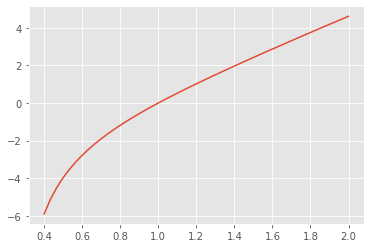

In [5]:
def stress(mat, lambda1):
    J = root_scalar(lambda J: mat.f(lambda1, J), bracket=(0, 10)).root
    return mat.stress(lambda1, J)

ls = np.linspace(.4, 2)
plt.plot(ls, [stress(mat, l) for l in ls]);

## Queueing

In a [simple queueing model](https://en.wikipedia.org/wiki/Queueing_theory#Simple_two-equation_queue), there is an arrival rate and a departure (serving) rate.  While waiting in the queue, there is a probability of "dropping out".  One model for the waiting time is given below.

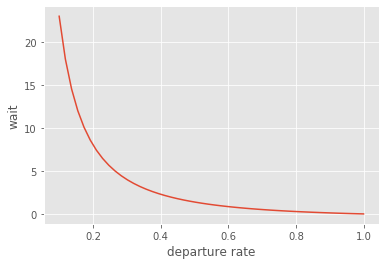

In [6]:
def wait(arrival, departure):
    return np.log(arrival / departure) / departure

ds = np.linspace(.1, 1)
plt.plot(ds, wait(1, ds))
plt.xlabel('departure rate')
plt.ylabel('wait');

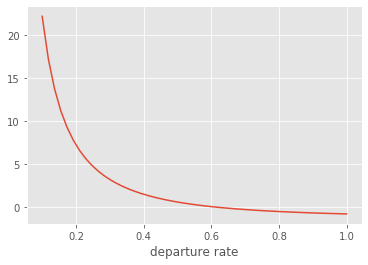

In [7]:
plt.plot(ds, wait(1, ds) - .8);
plt.xlabel('departure rate');

## Numerical methods

Let's consider some test functions, defined here along with their derivatives which we'll use later.

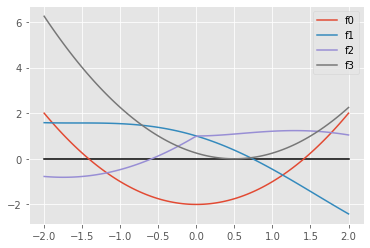

In [8]:
tests = []

@tests.append
def f0(x):
    return x*x - 2, 2*x

@tests.append
def f1(x):
    return np.cos(x) - x, -np.sin(x) - 1

@tests.append
def f2(x):
    return (np.exp(-np.abs(x)) + np.sin(x),
            np.exp(-np.abs(x))*(-np.sign(x)) + np.cos(x))

@tests.append
def f3(x):
    return x*x - x + 0.25, 2*x - 1

x = np.linspace(-2,2,100)
plt.plot(x, 0*x, color='k')
for f in tests:
    plt.plot(x, f(x)[0], label=f.__name__)
plt.legend(loc='upper right');

* Which of these functions have at least one root?
* Which have more than one root?
* Can we determine these properties merely by evaluating $f(x)$ for some values of $x$?

## Bisection

Bisection is a rootfinding technique that starts with an interval $[a,b]$ containing a root and does not require derivatives.

In [9]:
def hasroot(f, a, b):
    """Assuming the function f(x) is continuous, return true
    if the sign changes within the interval (a,b), thereby
    guaranteeing the existence of a root.
    
    Note that returning False does not guarantee that a root
    does not exist.
    """
    return f(a)[0]*f(b)[0] < 0
    
def bisect(f, a, b, history=None):
    mid = (a + b)/2.
    if b-a < 1e-5:
        if history is None:
            return mid
        else:
            return mid, np.array(history)
    if history is not None:
        history.append(mid)
    if hasroot(f, a, mid):
        return bisect(f, a, mid, history)
    else:
        return bisect(f, mid, b, history)

* Notice that we need to define `hasroot` above.

Let's try running it:

In [10]:
bisect(tests[0], -1, 2)

1.4142141342163086

In [11]:
np.sqrt(2) - bisect(tests[0], 0, 2)

2.2891797357704746e-06

We get about 5 digits of accuracy.  Why?  How fast did we get there?

In [12]:
x, h = bisect(tests[0], 0, 2, history=[])
x, h.tolist()

(1.4142112731933594,
 [1.0,
  1.5,
  1.25,
  1.375,
  1.4375,
  1.40625,
  1.421875,
  1.4140625,
  1.41796875,
  1.416015625,
  1.4150390625,
  1.41455078125,
  1.414306640625,
  1.4141845703125,
  1.41424560546875,
  1.414215087890625,
  1.4141998291015625,
  1.4142074584960938])

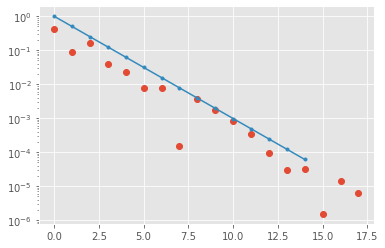

In [13]:
# Compute and plot errors
err = h - np.sqrt(2)
plt.semilogy(np.abs(err), 'o')
plt.semilogy(.5**np.arange(15), '.-');

Can you find any problems with this implementation?  List them below:

* No error checking
* 

Let's try running it on the rest of the test problem set:

In [14]:
for f in tests:
    x = bisect(f, -2, 2.1)
    print(f.__name__, x, f(x))

f0 -1.4142136573791504 (2.687177129701013e-07, -2.828427314758301)
f1 0.7390824317932131 (4.521129570500548e-06, -1.673610032599957)
f2 -0.588533115386963 (-5.151006675641057e-07, 1.3868969178207355)
f3 2.0999960899353027 (2.5599874878082574, 3.1999921798706055)


What's going wrong here?  How can we improve the implementation and what are fundamental limitations of the algorithm?

### Convergence rate

Let's quantitatively revisit the convergence rate.  A convergent rootfinding algorithm produces a sequence of approximations $x_i$ such that $$\lim_{i \to \infty} x_i \to x_*$$ where $f(x_*) = 0$.  For analysis, it is convenient to define the errors $e_i = x_i - x_*$. We say that an iterative algorithm is **$q$-linearly convergent** if $$\lim_{i \to \infty} |e_{i+1}| / |e_i| = \rho < 1.$$  (The $q$ is for "quotient".)  A smaller convergence factor $\rho$ represents faster convergence.  A slightly weaker condition ($r$-linear convergence or just **linear convergence**) is that
$$ |e_i| \le \epsilon_i $$
for all sufficiently large $i$ when the sequence $\{\epsilon_i\}$ converges $q$-linearly to 0.

Which criteria does the bisection method satisfy?  What is $\rho$ for bisection?

### Remarks on bisection

* Specifying an interval is often inconvenient
* An interval in which the function changes sign guarantees convergence (robustness)
* No derivative information is required
* Roots of even degree are problematic
* A bound on the solution error is directly available
* The convergence rate is modest -- one iteration per bit of accuracy

## Newton-Raphson Method

Much of numerical analysis reduces to [Taylor series](https://en.wikipedia.org/wiki/Taylor_series), the approximation
$$ f(x) = f(x_0) + f'(x_0) (x-x_0) + f''(x_0) (x - x_0)^2 / 2 + \underbrace{\dotsb}_{O((x-x_0)^3)} $$
centered on some reference point $x_0$.

In numerical computation, it is exceedingly rare to look beyond the first-order approximation
$$ \tilde f_{x_0}(x) = f(x_0) + f'(x_0)(x - x_0) . $$
Since $\tilde f_{x_0}(x)$ is a linear function, we can explicitly compute the unique solution of $\tilde f_{x_0}(x) = 0$ as
$$ x = x_0 - f(x_0) / f'(x_0) . $$
This is Newton's Method (aka Newton-Raphson or Newton-Raphson-Simpson) for finding the roots of differentiable functions.

In [15]:
def newton(func, x, verbose=False):
    """Solve f(x) = 0 using initial guess x.
    
    The provided function func must return a pair of values,
    f(x) and its derivative f'(x).  For example, to solve
    the equation x^2 - 3 starting from initial guess x=1,
    one would write
    
    def func(x):
        return x**2 - 3, 2*x
        
    newton(func, 1)
    """
    for i in range(100):
        fx, dfx = func(x)
        if verbose:
            print(func.__name__, i, x, fx)
        if np.abs(fx) < 1e-12:
            return x, fx, i
        try:
            x -= fx / dfx
        except ZeroDivisionError:
            return x, np.NaN, i

for f in tests:
    print(f.__name__, newton(f, 1, verbose=False))

f0 (1.4142135623730951, 4.440892098500626e-16, 5)
f1 (0.7390851332151607, 0.0, 4)
f2 (-6.285049273382587, -1.4268100589909238e-16, 4)
f3 (0.5000009536743164, 9.094947017729282e-13, 19)


* This output is kinda hard to read, so let's make it cleaner.

In [16]:
for f in tests:
    print(f.__name__, '{0:15.12f} {1:8.2e} {2:2d}'.format(
        *newton(f, -0.1)))

f0 -1.414213562373 1.33e-15  8
f1  0.739085133215 0.00e+00  5
f2 -0.588532743981 5.55e-13  4
f3  0.499999427800 3.27e-13 20


In [17]:
# Or as a table using the Pandas library
import pandas as pd
pd.DataFrame([(f.__name__, *newton(f, -0.1)) for f in tests],
             columns=('Name', 'Root', 'Residual', '# its'))

,Name,Root,Residual,# its
0,f0,-1.414214,1.332268e-15,8
1,f1,0.739085,0.000000e+00,5
2,f2,-0.588533,5.553336e-13,4
3,f3,0.499999,3.274048e-13,20


* Did we solve all of these equations?
* How can the iteration break down?
* Does choosing a different initial guess lead to different solutions?
* How is this convergence test different from the one we used for bisection?
* Is the convergence rate similar for all test equations?

## Convergence of Newton-type algorithms

We would like to know sharp conditions on when Newton-type algorithms converge, and if so, how fast.  This theory will build on that for a general *Fixed Point Iteration*.

### Fixed Point Iteration
Consider the iteration
$$x_{i+1} = g(x_i)$$
where $g$ is a continuously differentiable function.
Suppose that there exists a fixed point $r = g(r)$.  By the [mean value theorem](https://en.wikipedia.org/wiki/Mean_value_theorem), we have that
$$ x_{i+1} - r = g(x_i) - g(r) = g'(c_i) (x_i - r) $$
for some $c_i$ between $x_i$ and $r$.
Taking absolute values, $$|e_{i+1}| = |g'(c_i)| |e_i|,$$ which converges to zero if $|g'(c_i)| < 1$.
If $|g'(r)| < 1$ then for any $\epsilon > 0$ there is a neighborhood of $r$ such that $|g'(c_i)| < |g'(r)| + \epsilon$ for all $c_i$ in that neighborhood (guaranteed any time $x_i$ is in the neighborhood).
Consequently, we have:

#### Theorem: Linear Convergence of Fixed Point Iteration

If $g$ is continuously differentiable, $r = g(r)$, and $|g'(r)| < 1$ then the fixed point iteration $x_{i+1} = g(x_i)$ is locally linearly convergent with rate $|g'(r)|$.

#### Example of convergence

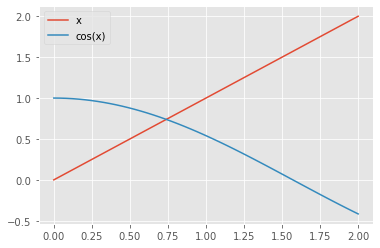

In [19]:
x = np.linspace(0, 2)
plt.plot(x, x, label='x')
plt.plot(x, np.cos(x), label='cos(x)')
plt.legend();

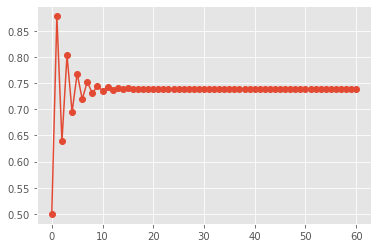

In [22]:
# Solve x = cos(x) using fixed point iteration
def fixed_point(g, x):
    xs = [x]
    for i in range(60):
        x = g(x)
        xs.append(x)
    return np.array(xs)

xs = fixed_point(np.cos, .5)
plt.plot(xs, 'o-');

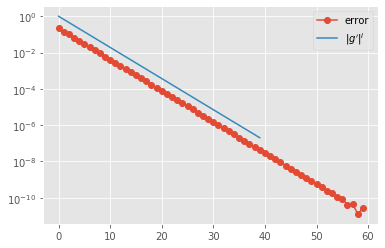

In [26]:
est_root = xs[-1]
plt.semilogy(np.abs(xs[:-1] - est_root), 'o-', label='error');
g_prime = np.sin(est_root)
plt.semilogy(g_prime ** np.arange(40), label="$|g'|^i$")
plt.legend();

#### Example of divergence

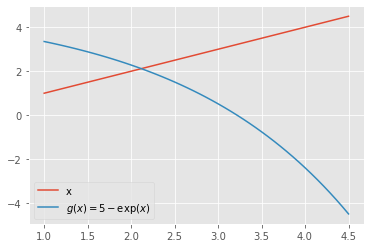

In [42]:
x = np.linspace(1, 4.5)
plt.plot(x, x, label='x')
plt.plot(x, 5 - np.exp(x/2), label='$g(x) = 5 - \exp(x)$')
plt.legend();

In [40]:
fixed_point(lambda x: 5 - np.exp(x/2), 1)[:10]

array([ 1.        ,  3.35127873, -0.34220968,  4.15726678, -2.99353741,
        4.77614767, -5.89249301,  4.94746347, -6.8666475 ,  4.96772053])

* Even if we start close to the root, it doesn't converge.
* We can explain this by calculating $g'(x)$ for an $x$ close to the root.  Eyeballing the graph, it appears that $r \approx 1.3$.

In [32]:
5 - np.exp(1.306)

1.308621372741963

$$ g'(x) = - \exp(1.306) $$

In [94]:
-np.exp(1.306)

-3.691378627258037

#### Observations, and a fresh derivation of Newton's method

* A rootfinding problem $f(x) = 0$ can be converted to a fixed point problem $$x = x - f(x) =: g(x)$$ but there is no guarantee that $g'(r) = 1 - f'(r)$ will have magnitude less than 1.
* Problem-specific algebraic manipulation can be used to make $|g'(r)|$ small.
* $x = x - f(x)h(x)$ is also a valid formulation for any $h(x)$ bounded away from $0$.
* Can we choose $h(x)$ such that $$ g'(x) = 1 - f(x) h'(x) - f'(x)h(x) = 0$$ when $f(x) = 0$?

In other words,
$$ x_{i+1} = x_i - f(x_i) \underbrace{\frac{1}{f'(x_i)}}_{h(x_i)} . $$

* It turns out that Newton's method has _locally quadratic_ convergence to simple roots,
$$\lim_{i \to \infty} \frac{|e_{i+1}|}{|e_i|^2} < \infty.$$
* "The number of correct digits doubles each iteration."
* Now that we know how to make a good guess accurate, the effort lies in getting a good guess.

#### Culture: fast inverse square root

The following code appeared literally (including comments) in the Quake III Arena source code (late 1990s).

```C
float Q_rsqrt( float number )
{
	long i;
	float x2, y;
	const float threehalfs = 1.5F;

	x2 = number * 0.5F;
	y  = number;
	i  = * ( long * ) &y;                       // evil floating point bit level hacking
	i  = 0x5f3759df - ( i >> 1 );               // what the fuck? 
	y  = * ( float * ) &i;
    y  = y * ( threehalfs - ( x2 * y * y ) );   // 1st iteration
//  y  = y * ( threehalfs - ( x2 * y * y ) );   // 2nd iteration, this can be removed

	return y;
}
```

We now have [vector instructions](https://software.intel.com/sites/landingpage/IntrinsicsGuide/#text=sqrt&expand=2989,1224,4470) for approximate inverse square root.
More at https://en.wikipedia.org/wiki/Fast_inverse_square_root